#

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle

from neurodsp.spectral import compute_spectrum
from specparam.plts.spectra import plot_spectrum


In [4]:
# custom imports
import sys
sys.path.append('../../sim_field')
from utils import sample_spikes, convolve_psps, get_spike_times


### settings

In [5]:
# simulation settings
N_SECONDS = 100
FS = 1000 # sampling frequency
N_NEURONS = 100
MEAN_RATE = 10 # average rate of each neuron (Hz)

# random process params
ALPHA = 1.
TAU_C = 25 / 1000

In [6]:
# matplotlib and figure appearance settings
# plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]


### functions

In [7]:
def sim_lfp(n_neurons=1000, mean_rate=2, n_seconds=10, fs=1000, 
            tau_rise=0., tau_decay=0.01, return_spikes=False):
    # imports
    from scipy.signal import detrend

    # simulate spiking
    spikes = []
    for i_neuron in range(n_neurons):
        rand_white = np.random.normal(loc=mean_rate, scale=mean_rate**0.5, size=n_seconds*fs)
        spikes_i = sample_spikes(rand_white, fs)
        spikes.append(spikes_i)
    spikes = np.array(spikes)
        
    # get spike times
    time = np.linspace(0, n_seconds, spikes.shape[1])
    spike_times = []
    for i_cell in range(len(spikes)):
        spike_times.append(get_spike_times(spikes[i_cell], time))

    # simulate LFP
    pop_spikes = np.sum(spikes, axis=0)
    lfp, time = convolve_psps(pop_spikes, fs, tau_r=tau_rise, tau_d=tau_decay)
    lfp = detrend(lfp, type='constant')

    # TEMP - correct time vector (this in a bug in convolve_psps)
    n_samples_dropped = len(time) - len(lfp)
    time = time[:-n_samples_dropped]

    if return_spikes:
        return spikes, spike_times, lfp, time
    else:
        return lfp, time


## Main

### simulate LFP

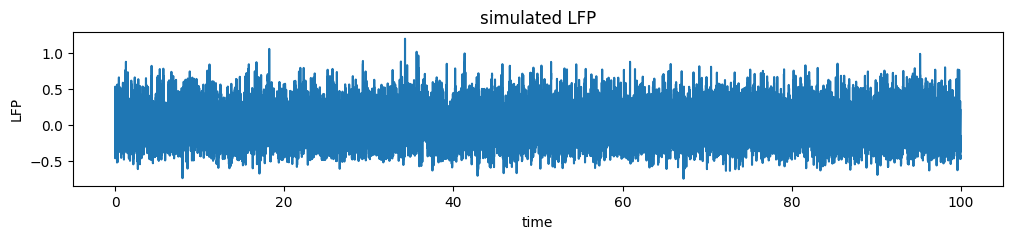

Text(0.5, 1.0, 'PSD of simulated LFP')

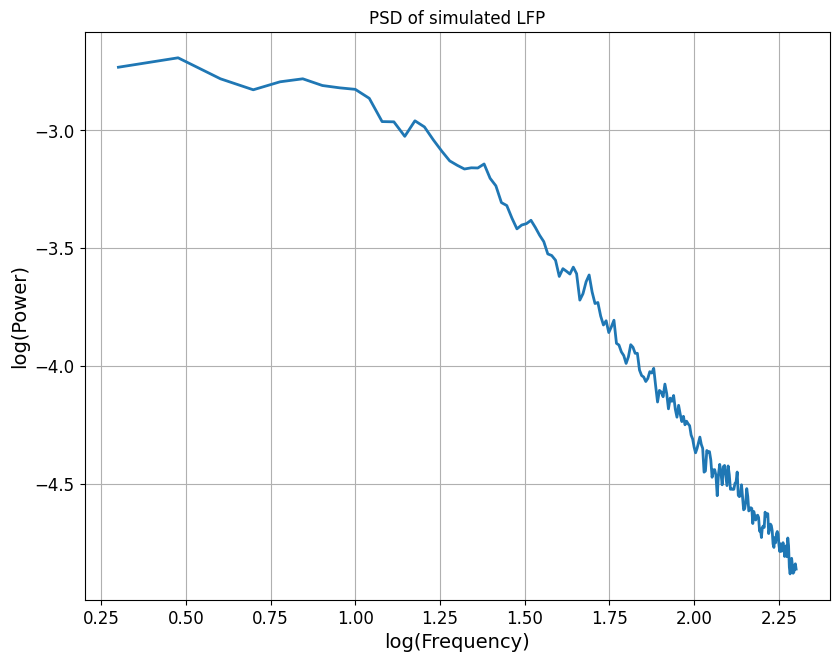

In [8]:
# simulate LFP 

# simulate LFP
spikes, spike_times, lfp, time = sim_lfp(n_neurons=N_NEURONS, mean_rate=MEAN_RATE, 
                                n_seconds=N_SECONDS, fs=FS, return_spikes=True)
freq, spectra = compute_spectrum(lfp, FS, f_range=[2,200])

# plot LFP time-series
fig, ax = plt.subplots(1,1, figsize=[12,2])
ax.plot(time, lfp)
ax.set(xlabel="time", ylabel="LFP")
ax.set_title("simulated LFP")
plt.show()

# plot spectrum
plot_spectrum(freq, spectra, log_freqs=True, log_powers=True)
ax = plt.gca()
ax.set_title("PSD of simulated LFP")


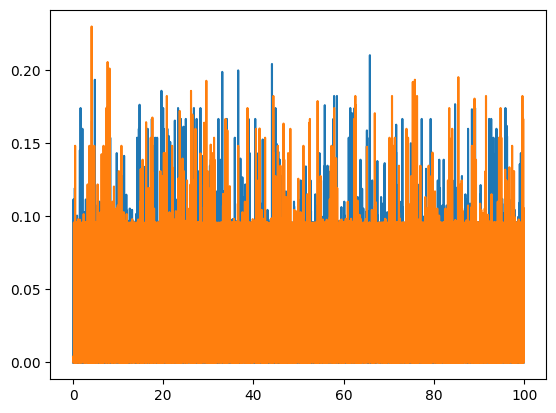

In [9]:
# plot conductance trace of each neuron

# compute traces
traces = []

for i_spiketrain in range(len(spikes)):
    i_trace, spike_time_vector = convolve_psps(spikes[i_spiketrain], FS)
    traces.append(i_trace)
traces = np.array(traces)
spike_time_vector = spike_time_vector[:traces.shape[1]] # TEMP - bug in convolve_psps
plt.plot(spike_time_vector, traces[:2].T);

### increase rate
offset : firing rate (Miller, 2009)

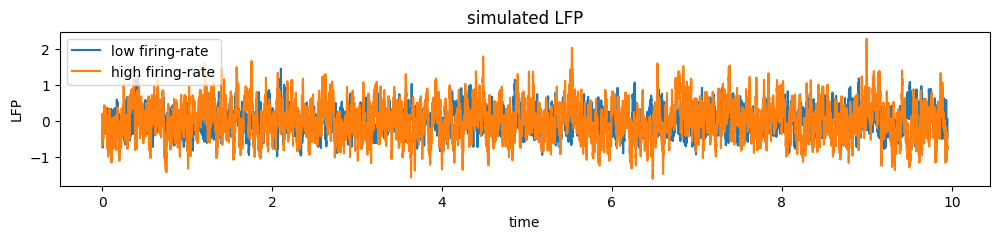

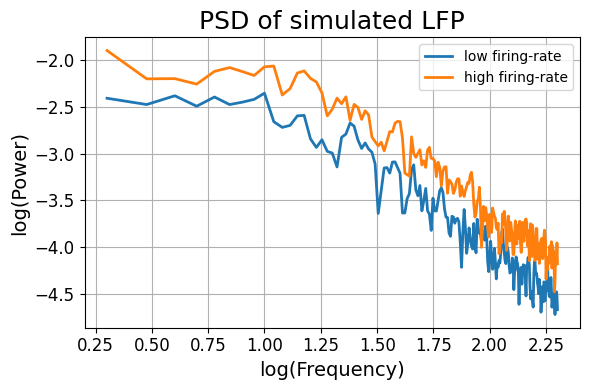

In [10]:
# simulate LFP with increased rate

# simulate LFP
spikes_0, spike_times_0, lfp_0, t_lfp_0 = sim_lfp(mean_rate=2, fs=FS, return_spikes=True)
spikes_1, spike_times_1, lfp_1, _ = sim_lfp(mean_rate=5, fs=FS, return_spikes=True)

# compute PSD
freq, spectra_0 = compute_spectrum(lfp_0, FS, f_range=[2,200])
freq, spectra_1 = compute_spectrum(lfp_1, FS, f_range=[2,200])

# plot LFP time-series
fig, ax = plt.subplots(1,1, figsize=[12,2])
ax.plot(t_lfp_0, lfp_0, label='low firing-rate')
ax.plot(t_lfp_0, lfp_1, label='high firing-rate')
ax.set(xlabel="time", ylabel="LFP")
ax.set_title("simulated LFP")
ax.legend()
plt.show()

# plot spectrum
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_title("PSD of simulated LFP")
plot_spectrum(freq, spectra_0, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq, spectra_1, log_freqs=True, log_powers=True, ax=ax)
ax.legend(labels=["low firing-rate","high firing-rate"])

### introduce excitatory and inhibitory population
exponent : EI balance (Gao, 2017)

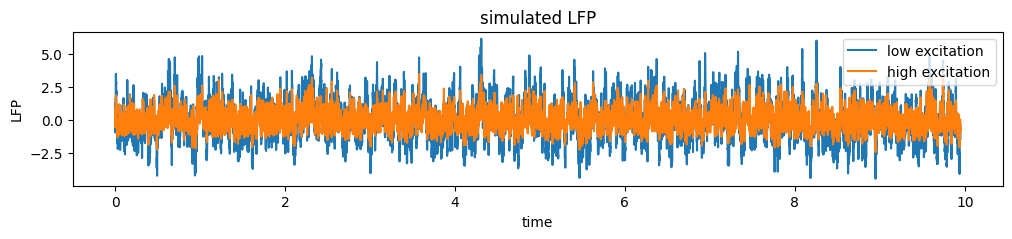

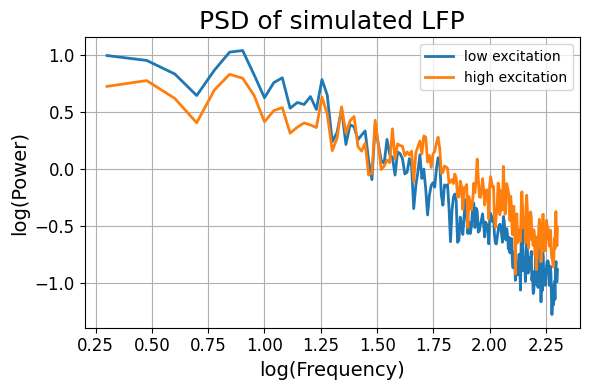

In [11]:
# simulate LFP with increased rate

# simulate excitatory and inhibitory fields
spikes_e, spiketimes_e, conductance_e, time_e = sim_lfp(n_neurons=800, mean_rate=2, tau_rise=0.0001, tau_decay=.002, return_spikes=True)
spikes_i, spiketimes_i, conductance_i, time_i = sim_lfp(n_neurons=200, mean_rate=5, tau_rise=0.0005, tau_decay=.01, return_spikes=True)

# TEMP ! trim to same length
n_samples = np.min([len(conductance_e), len(conductance_i)]) 
conductance_e = conductance_e[:n_samples]
conductance_i = conductance_i[:n_samples]
t_lfp_2 = time_e[:n_samples]

# combine LFP
lfp_2 = conductance_e + 6 * conductance_i
lfp_3 = conductance_e + 2 * conductance_i

# compute PSD and normalize
freq, spectra_2 = compute_spectrum(lfp_2, FS, f_range=[2,200])
freq, spectra_3 = compute_spectrum(lfp_3, FS, f_range=[2,200])
spectra_2 = spectra_2 / np.mean(spectra_2)
spectra_3 = spectra_3 / np.mean(spectra_3)

# plot LFP time-series
fig, ax = plt.subplots(1,1, figsize=[12,2])
ax.plot(t_lfp_2, lfp_2-np.mean(lfp_2), label='low excitation')
ax.plot(t_lfp_2, lfp_3-np.mean(lfp_3), label='high excitation')
ax.set(xlabel="time", ylabel="LFP")
ax.set_title("simulated LFP")
ax.legend()
plt.show()

# plot spectrum
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_title("PSD of simulated LFP")
plot_spectrum(freq, spectra_2, log_freqs=True, log_powers=True, ax=ax)
plot_spectrum(freq, spectra_3, log_freqs=True, log_powers=True, ax=ax)
ax.legend(labels=["low excitation","high excitation"])

### simulate PSPs

In [12]:

def sim_psp(fs, tau_r=0., tau_d=0.01, t_ker=None):
    """
    sim post-synaptic potential (PSP) kernel
    """
    from neurodsp.sim.transients import sim_synaptic_kernel
    from neurodsp.utils import create_times
    
    # If not provided, compute t_ker as a function of decay time constant
    if t_ker is None:
        t_ker = 5. * tau_d

    # Simulate
    kernel = sim_synaptic_kernel(t_ker, fs, tau_r, tau_d)
    n_seconds = len(kernel) / fs
    time = create_times(n_seconds, fs)

    return kernel, time

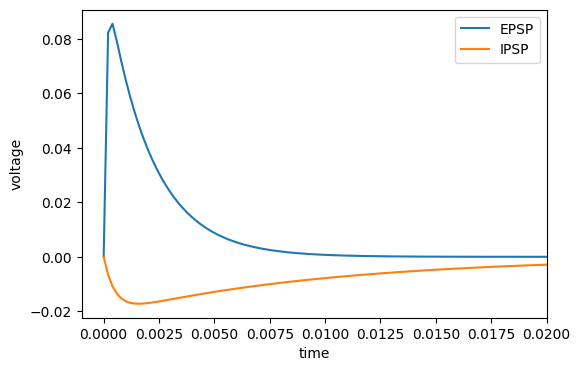

In [13]:
# simulate currents
kernel_e, time_ke = sim_psp(5000, tau_r=0.0001, tau_d=0.002, t_ker=0.05)
kernel_i, time_ki = sim_psp(5000, tau_r=0.0005, tau_d=0.01, t_ker=0.05)

# plot
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(time_ke, kernel_e, label='EPSP')
ax.plot(time_ki, -kernel_i, label='IPSP')
ax.set(xlabel="time", ylabel="voltage")
ax.legend()
ax.set_xlim(-0.001,0.02)
ax.set_title("")
plt.show()

### plot aggregate figure

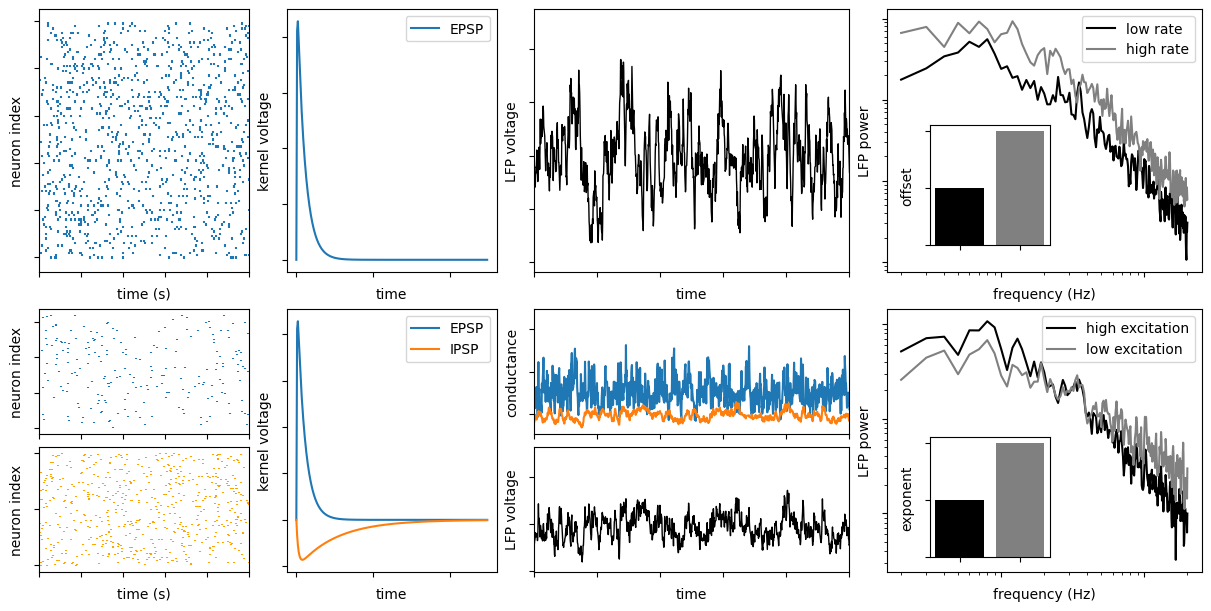

In [14]:
# create figure and gridspec
fig = plt.figure(figsize=[12,6], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=4, nrows=2, width_ratios=[1,1,1.5,1.5], height_ratios=[1,1])

### Plot top row #################
ax_1a = fig.add_subplot(spec[0,0])
ax_1b = fig.add_subplot(spec[0,1])
ax_1c = fig.add_subplot(spec[0,2])
ax_1d = fig.add_subplot(spec[0,3])

# plot subplot 1a
ax_1a.eventplot(spike_times)
ax_1a.set(xlabel="time (s)", ylabel="neuron index")

# plot subplot 1b
ax_1b.plot(time_ke, kernel_e, label="EPSP")
ax_1b.set(xlabel="time", ylabel="kernel voltage")
ax_1b.legend()

# plot subplot 1c
# create nested gridspec
ax_1c.plot(t_lfp_0, lfp_0, color='k', linewidth=1)
ax_1c.set(xlabel="time", ylabel="LFP voltage")

# plot subplot 1d
ax_1d.loglog(freq, spectra_0, color='k')
ax_1d.loglog(freq, spectra_1, color='grey')
ax_1d.set(xlabel="frequency (Hz)", ylabel="LFP power")
ax_1d.legend(labels=["low rate","high rate"], loc="upper right")

# plot subplot 1e (embedding in 1d)
ax_1e = fig.add_axes([.77,0.60,.1,.2], zorder=10, anchor='SW')
ax_1e.bar([0,1], [1,2], color=['k','grey']) # TEMP - placeholder
ax_1e.set(ylabel="offset")

### Plot bottom row #################
# ax_2a = fig.add_subplot(spec[1,0])
ax_2b = fig.add_subplot(spec[1,1])
# ax_2c = fig.add_subplot(spec[1,2])
ax_2d = fig.add_subplot(spec[1,3])

# plot subplot 2a
# create nested gridspec
spec_2a = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=spec[1,0])
ax_2a_a = fig.add_subplot(spec_2a[0,0])
ax_2a_b = fig.add_subplot(spec_2a[1,0])
ax_2a_a.eventplot(spiketimes_e)
ax_2a_b.eventplot(spiketimes_i, color='orange')
ax_2a_a.set(xlabel="", ylabel="neuron index")
ax_2a_b.set(xlabel="time (s)", ylabel="neuron index")

# plot subplot 2b
ax_2b.plot(time_ke, kernel_e, label='EPSP')
ax_2b.plot(time_ki, -kernel_i, label='IPSP')
ax_2b.set(xlabel="time", ylabel="kernel voltage")
ax_2b.legend()

# plot subplot 2c
spec_2c = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=spec[1,2])
ax_2c_a = fig.add_subplot(spec_2c[0,0])
ax_2c_a.plot(t_lfp_2, conductance_e+np.max(conductance_i), label='excitatory')
ax_2c_a.plot(t_lfp_2, conductance_i, label='inhibitory')
ax_2c_a.set(ylabel="conductance")

ax_2c_b = fig.add_subplot(spec_2c[1,0])
ax_2c_b.plot(t_lfp_2, lfp_2, color='k', linewidth=1)
ax_2c_b.set(xlabel="time", ylabel="LFP voltage")

# plot subplot 2d
ax_2d.loglog(freq, spectra_2, color='k')
ax_2d.loglog(freq, spectra_3, color='grey')
ax_2d.set(xlabel="frequency (Hz)", ylabel="LFP power")
ax_2d.legend(labels=["high excitation","low excitation"], loc="upper right")

# plot subplot 2e (embedding in 2d)
ax_2e = fig.add_axes([.77,0.08,.1,.2], zorder=10, anchor='SW')
ax_2e.bar([0,1], [1,2], color=['k','grey']) # TEMP - placeholder
ax_2e.set(ylabel="exponent")

# set x limits
for ax in[ax_1a, ax_2a_a, ax_2a_b, ax_1c, ax_2c_a, ax_2c_b]:
    ax.set_xlim([0,1])

# turn off all axis tick labels
for ax in [ax_1a, ax_1b, ax_1c, ax_1d, ax_2a_a, ax_2a_b, ax_2b, ax_2c_a, ax_2c_b, ax_2d, ax_1e, ax_2e]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

TypeError: set_ticks() got an unexpected keyword argument 'labels'

C:\Users\User\.conda\envs\neomne\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


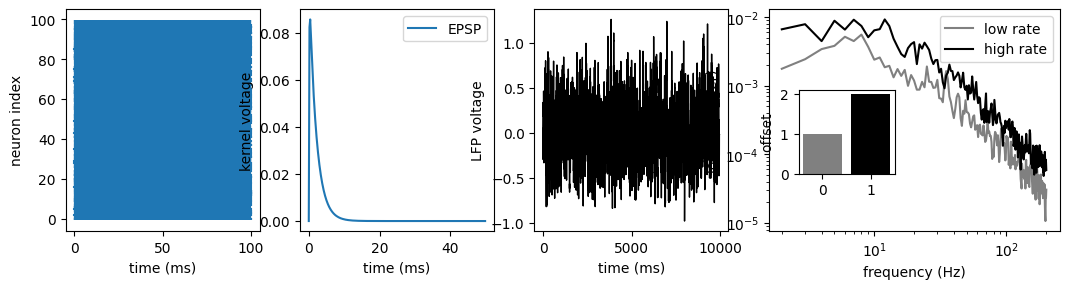

In [15]:
# create figure and gridspec
fig = plt.figure(figsize=[12,6], tight_layout=True)
spec = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[1,0.0001,1])

# create gridspec for each row (model)
gs_r0 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=spec[0,0], width_ratios=[0.7,1,1,1,1.5], height_ratios=[1])
gs_pad = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=spec[1,0])
gs_r1 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=spec[2,0], width_ratios=[0.7,1,1,1,1.5], height_ratios=[1])

########## Row 1: offset model ##########
ax_1b = fig.add_subplot(gs_r0[0,1])
ax_1c = fig.add_subplot(gs_r0[0,2])
ax_1d = fig.add_subplot(gs_r0[0,3])
ax_1e = fig.add_subplot(gs_r0[0,4])

# plot subplot 1b
ax_1b.eventplot(spike_times)
ax_1b.set(xlabel="time (ms)", ylabel="neuron index")

# plot subplot 1c
ax_1c.plot(time_ke*1000, kernel_e, label="EPSP")
ax_1c.set(xlabel="time (ms)", ylabel="kernel voltage")
ax_1c.legend()

# plot subplot 1d
# create nested gridspec
ax_1d.plot(t_lfp_0*1000, lfp_0, color='k', linewidth=1)
ax_1d.set(xlabel="time (ms)", ylabel="LFP voltage")

# plot subplot 1e
ax_1e.loglog(freq, spectra_0, color='grey')
ax_1e.loglog(freq, spectra_1, color='k')
ax_1e.set(xlabel="frequency (Hz)", ylabel="log(LFP power)")
ax_1e.legend(labels=["low rate","high rate"], loc="upper right")

# plot subplot 1f (embedding in 1e)
ax_1f = fig.add_axes([.77, 0.70, .08, .14], zorder=10, anchor='SW')
ax_1f.bar([0,1], [1,2], color=['grey','k']) # TEMP - placeholder
ax_1f.set(ylabel="offset")
ax_1f.set_xticks([0,1], labels=['low-rate', 'high-rate'], rotation=15)

### Plot bottom row #################

# plot subplot 2b
# create nested gridspec
gs_r2_b = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_r1[0,1])
ax_2b_a = fig.add_subplot(gs_r2_b[0,0])
ax_2b_a.eventplot(spiketimes_e)

ax_2b_b = fig.add_subplot(gs_r2_b[1,0])
ax_2b_b.eventplot(spiketimes_i, color='orange')
ax_2b_b.set(xlabel="time", ylabel="neuron index")

# plot subplot 2c
ax_2c = fig.add_subplot(gs_r1[0,2])
ax_2c.plot(time_ke*1000, kernel_e, label='EPSP')
ax_2c.plot(time_ki*1000, -kernel_i, label='IPSP')
ax_2c.set(xlabel="time (ms)", ylabel="kernel voltage")
ax_2c.legend()

# plot subplot 2d
gs_r2_d = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_r1[0,3])
ax_2d_a = fig.add_subplot(gs_r2_d[0,0])
ax_2d_a.plot(t_lfp_2*1000, conductance_e+np.max(conductance_i), label='excitatory')
ax_2d_a.plot(t_lfp_2*1000, conductance_i, label='inhibitory')
ax_2d_a.set(ylabel="conductance")

ax_2d_b = fig.add_subplot(gs_r2_d[1,0])
ax_2d_b.plot(t_lfp_2*1000, lfp_2, color='k', linewidth=1)
ax_2d_b.set(xlabel="time (ms)", ylabel="LFP voltage")

# plot subplot 2d
ax_2e = fig.add_subplot(gs_r1[0,4])
ax_2e.loglog(freq, spectra_3, color='grey')
ax_2e.loglog(freq, spectra_2, color='k')
ax_2e.set(xlabel="frequency (Hz)", ylabel="log(LFP power)")
ax_2e.legend(labels=["low E:I","high E:I"], loc="upper right")

# plot subplot 2e (embedding in 2d)
ax_2f = fig.add_axes([.77, 0.16, .08, .14], zorder=10, anchor='SW')
ax_2f.bar([0,1], [2,1], color=['grey','k']) # TEMP - placeholder
ax_2f.set(ylabel="exponent")
ax_2f.set_xticks([0,1], labels=['low-E:I', 'high-E:I'], rotation=15)

# set x limits
for ax in[ax_1d, ax_2d_a, ax_2d_b]:
    ax.set_xlim([0, 200])
for ax in[ax_1b, ax_2b_a, ax_2b_b]:
    ax.set_xlim([0, 0.2])

# adjust axis ticks and labels
for ax in [ax_1b, ax_1c, ax_1d, ax_1e, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, ax_2d_b, ax_2e, ax_2f]:
    # ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])

for ax in[ax_2b_a, ax_2d_a]:
    ax.set_xticklabels([])

for ax in [ax_1b, ax_1c, ax_1d, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, ax_2d_b, ax_2f]:
    ax.yaxis.set_label_coords(0, .5)
for ax in [ax_1e, ax_2e]:
    ax.yaxis.set_label_coords(-0.02, .5)

for ax in[ax_1e, ax_2e]:
    ax.set_xticks([10,100], labels=('10', '100'))

for ax in[ax_1d, ax_2d_a, ax_2d_b]:
    ax.set_xticks([0, 100, 200], labels=('0', '100', '200'))

for ax in [ax_1b, ax_2b_b]:
    ax.set_xticks([0, 0.1, 0.2], labels=['0','100','200'])
    ax.set(xlabel="time (ms)", ylabel="neuron index")
ax_2b_a.set_xticks([0, 0.1, 0.2], labels=[])
ax_2b_a.set(xlabel="", ylabel="neuron index")

# add placeholder subplots for model cartoon
ax_1a = fig.add_subplot(gs_r0[0,0])
ax_2a = fig.add_subplot(gs_r1[0,0])
for ax in [ax_1a, ax_2a]:
    ax.set_axis_off()

# color each row
fig.add_artist(Rectangle((0, 0.51), width=1, height=0.5, facecolor='grey', alpha=0.4, zorder=0))
fig.add_artist(Rectangle((0, .0), width=1, height=0.49, facecolor='grey', alpha=0.4, zorder=0))

plt.show()

TypeError: set_ticks() got an unexpected keyword argument 'labels'

C:\Users\User\.conda\envs\neomne\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


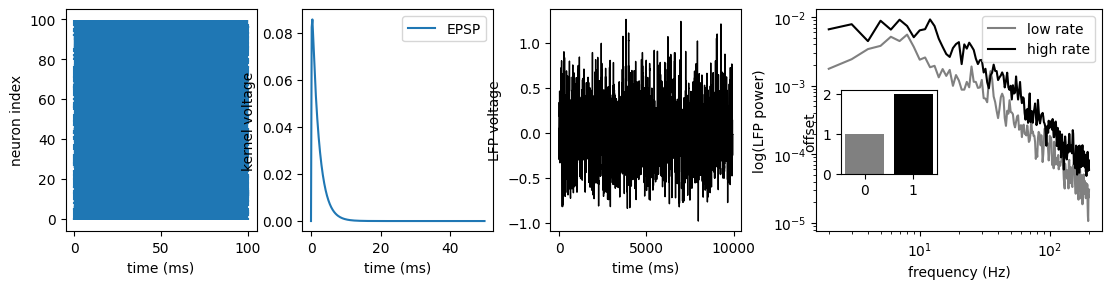

In [16]:
# create figure and gridspec
fig = plt.figure(figsize=[12,6], tight_layout=True)
spec = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[1,0.0001,1])

# create gridspec for each row (model)
eq_ax_size = 0.3
gs_r0 = gridspec.GridSpecFromSubplotSpec(1, 8, subplot_spec=spec[0,0], width_ratios=[0.7,1,eq_ax_size*0.8,1,eq_ax_size,1,eq_ax_size*1.3,1.5], 
                                         height_ratios=[1], wspace=0)
gs_pad = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=spec[1,0])
gs_r1 = gridspec.GridSpecFromSubplotSpec(1, 8, subplot_spec=spec[2,0], width_ratios=[0.7,1,eq_ax_size*0.8,1,eq_ax_size,1,eq_ax_size*1.3,1.5], 
                                         height_ratios=[1], wspace=0)

########## Row 1: offset model ##########
ax_1b = fig.add_subplot(gs_r0[0,1])
ax_1c = fig.add_subplot(gs_r0[0,3])
ax_1d = fig.add_subplot(gs_r0[0,5])
ax_1e = fig.add_subplot(gs_r0[0,7])

# plot subplot 1b
ax_1b.eventplot(spike_times)
ax_1b.set(xlabel="time (ms)", ylabel="neuron index")

# plot subplot 1c
ax_1c.plot(time_ke*1000, kernel_e, label="EPSP")
ax_1c.set(xlabel="time (ms)", ylabel="kernel voltage")
ax_1c.legend()

# plot subplot 1d
# create nested gridspec
ax_1d.plot(t_lfp_0*1000, lfp_0, color='k', linewidth=1)
ax_1d.set(xlabel="time (ms)", ylabel="LFP voltage")

# plot subplot 1e
ax_1e.loglog(freq, spectra_0, color='grey')
ax_1e.loglog(freq, spectra_1, color='k')
ax_1e.set(xlabel="frequency (Hz)", ylabel="log(LFP power)")
ax_1e.legend(labels=["low rate","high rate"], loc="upper right")

# plot subplot 1f (embedding in 1e)
ax_1f = fig.add_axes([.77, 0.70, .08, .14], zorder=10, anchor='SW')
ax_1f.bar([0,1], [1,2], color=['grey','k']) # TEMP - placeholder
ax_1f.set(ylabel="offset")
ax_1f.set_xticks([0,1], labels=['low-rate', 'high-rate'], rotation=15)

### Plot bottom row ###################################################

# plot subplot 2b
# create nested gridspec
gs_r2_b = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_r1[0,1])
ax_2b_a = fig.add_subplot(gs_r2_b[0,0])
ax_2b_a.eventplot(spiketimes_e)

ax_2b_b = fig.add_subplot(gs_r2_b[1,0])
ax_2b_b.eventplot(spiketimes_i, color='orange')
ax_2b_b.set(xlabel="time", ylabel="neuron index")

# plot subplot 2c
ax_2c = fig.add_subplot(gs_r1[0,3])
ax_2c.plot(time_ke*1000, kernel_e, label='EPSP')
ax_2c.plot(time_ki*1000, -kernel_i, label='IPSP')
ax_2c.set(xlabel="time (ms)", ylabel="kernel voltage")
ax_2c.legend()

# plot subplot 2d
gs_r2_d = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_r1[0,5], height_ratios=[1,0.5,1], hspace=0)
ax_2d_eq = fig.add_subplot(gs_r2_d[1,0])
ax_2d_eq.set_axis_off()
ax_2d_eq.text(0.35,0.1, "\u03A3\u21d3", size=24)

ax_2d_a = fig.add_subplot(gs_r2_d[0,0])
# ax_2d_a.plot(t_lfp_2*1000, conductance_e+np.max(conductance_i), label='excitatory')
ax_2d_a.plot(t_lfp_2*1000, conductance_e, label='excitatory')
ax_2d_a.plot(t_lfp_2*1000, conductance_i, label='inhibitory')
ax_2d_a.set(ylabel="current")

ax_2d_b = fig.add_subplot(gs_r2_d[2,0])
ax_2d_b.plot(t_lfp_2*1000, lfp_2, color='k', linewidth=1)
ax_2d_b.set(xlabel="time (ms)", ylabel="LFP voltage")

# plot subplot 2d
ax_2e = fig.add_subplot(gs_r1[0,7])
ax_2e.loglog(freq, spectra_3, color='grey')
ax_2e.loglog(freq, spectra_2, color='k')
ax_2e.set(xlabel="frequency (Hz)", ylabel="log(LFP power)")
ax_2e.legend(labels=["low E:I","high E:I"], loc="upper right")

# plot subplot 2e (embedding in 2d)
ax_2f = fig.add_axes([.77, 0.16, .08, .14], zorder=10, anchor='SW')
ax_2f.bar([0,1], [2,1], color=['grey','k']) # TEMP - placeholder
ax_2f.set(ylabel="exponent")
ax_2f.set_xticks([0,1], labels=['low-E:I', 'high-E:I'], rotation=15)

# set x limits
for ax in[ax_1d, ax_2d_a, ax_2d_b]:
    ax.set_xlim([0, 200])
for ax in[ax_1b, ax_2b_a, ax_2b_b]:
    ax.set_xlim([0, 0.2])

# adjust axis ticks and labels
for ax in [ax_1b, ax_1c, ax_1d, ax_1e, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, ax_2d_b, ax_2e, ax_2f]:
    # ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])

for ax in[ax_2b_a, ax_2d_a]:
    ax.set_xticklabels([])

for ax in [ax_1b, ax_1c, ax_1d, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, ax_2d_b, ax_2f]:
    ax.yaxis.set_label_coords(0, .5)
for ax in [ax_1e, ax_2e]:
    ax.yaxis.set_label_coords(-0.02, .5)

for ax in[ax_1e, ax_2e]:
    ax.set_xticks([10,100], labels=('10', '100'))

for ax in[ax_1d, ax_2d_b]:
    ax.set_xticks([0, 100, 200], labels=('0', '100', '200'))

for ax in [ax_1b, ax_2b_b]:
    ax.set_xticks([0, 0.1, 0.2], labels=['0','100','200'])
    ax.set(xlabel="time (ms)", ylabel="neuron index")
ax_2b_a.set_xticks([0, 0.1, 0.2], labels=[])
ax_2b_a.set(xlabel="", ylabel="neuron index")

# add placeholder subplots for model cartoon
ax_1a = fig.add_subplot(gs_r0[0,0])
ax_2a = fig.add_subplot(gs_r1[0,0])
for ax in [ax_1a, ax_2a]:
    ax.set_axis_off()
ax_1a.text(0,0.2, "~model cartoon~", multialignment='center', rotation=45) # TEMP
ax_2a.text(0,0.2, "~model cartoon~", multialignment='center', rotation=45) # TEMP

# color each row
fig.add_artist(Rectangle((0, 0.51), width=1, height=0.5, facecolor='grey', alpha=0.4, zorder=0))
fig.add_artist(Rectangle((0, .0), width=1, height=0.49, facecolor='grey', alpha=0.4, zorder=0))

# add equation symbols between plots
ax_1eq0 = fig.add_subplot(gs_r0[0,2])
ax_1eq1 = fig.add_subplot(gs_r0[0,4])
ax_1eq2 = fig.add_subplot(gs_r0[0,6])
ax_2eq0 = fig.add_subplot(gs_r1[0,2])
ax_2eq1 = fig.add_subplot(gs_r1[0,4])
ax_2eq2 = fig.add_subplot(gs_r1[0,6])

for ax in [ax_1eq0, ax_1eq1, ax_1eq2, ax_2eq0, ax_2eq1, ax_2eq2]:
    ax.set_axis_off()
eq_size = 32
ax_1eq0.text(0.1, 0.4, "\u002a", size=eq_size)
ax_1eq1.text(0, 0.4, "=", size=eq_size)
ax_1eq2.text(0.1, 0.28, "\u2131 \n\u21D4", size=eq_size)

ax_2eq0.text(0.1, 0.4, "\u002a", size=eq_size)
ax_2eq1.text(0, 0.7, "=", size=eq_size)
ax_2eq2.text(0.1, -0.03, "\u2131 \n\u21D4", size=eq_size)

plt.show()

In [ ]:
# create figure and gridspec
fig = plt.figure(figsize=[12,6], tight_layout=True)
spec = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[1,0.4,1], hspace=0)

# create gridspec for each row (model)
eq_ax_size = 0.3
gs_r0 = gridspec.GridSpecFromSubplotSpec(1, 8, subplot_spec=spec[0,0], width_ratios=[0.7,1,eq_ax_size*0.8,1,eq_ax_size,1,eq_ax_size*1.3,1.5], 
                                         height_ratios=[1], wspace=0)
gs_pad = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=spec[1,0])
gs_r1 = gridspec.GridSpecFromSubplotSpec(1, 8, subplot_spec=spec[2,0], width_ratios=[0.7,1,eq_ax_size*0.8,1,eq_ax_size,1,eq_ax_size*1.3,1.5], 
                                         height_ratios=[1], wspace=0)
ax_r0 = fig.add_subplot(spec[0,0])
ax_r0.set_axis_off()
ax_r0.set_title('Aperiodic offset indexes neural firing rate (Miller, 2009)', 
                fontsize=14, loc='left')

ax_r1 = fig.add_subplot(spec[2,0])
ax_r1.set_axis_off()
ax_r1.set_title('Aperiodic exponent indexes E:I balance (Gao, 2017)', 
                fontsize=14, loc='left')

########## Row 1: offset model ##########
ax_1b = fig.add_subplot(gs_r0[0,1])
ax_1c = fig.add_subplot(gs_r0[0,3])
ax_1d = fig.add_subplot(gs_r0[0,5])
ax_1e = fig.add_subplot(gs_r0[0,7])

# plot subplot 1b
ax_1b.eventplot(spike_times)
ax_1b.set(xlabel="time (ms)", ylabel="neuron index")

# plot subplot 1c
ax_1c.plot(time_ke*1000, kernel_e, label="EPSP")
ax_1c.set(xlabel="time (ms)", ylabel="kernel voltage")
ax_1c.legend()

# plot subplot 1d
# create nested gridspec
ax_1d.plot(t_lfp_0*1000, lfp_0, color='k', linewidth=1)
ax_1d.set(xlabel="time (ms)", ylabel="LFP voltage")

# plot subplot 1e
ax_1e.loglog(freq, spectra_0, color='grey')
ax_1e.loglog(freq, spectra_1, color='k')
ax_1e.set(xlabel="frequency (Hz)", ylabel="log(LFP power)")
ax_1e.legend(labels=["low rate","high rate"], loc="upper right")

# plot subplot 1f (embedding in 1e)
ax_1f = fig.add_axes([.77, 0.66, .08, .14], zorder=10, anchor='SW')
ax_1f.bar([0,1], [1,2], color=['grey','k']) # TEMP - placeholder
ax_1f.set(ylabel="offset")
ax_1f.set_xticks([0,1], labels=['low-rate', 'high-rate'], rotation=15)

### Plot bottom row ###################################################

# plot subplot 2b
# create nested gridspec
gs_r2_b = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_r1[0,1], hspace=0.1)
ax_2b_a = fig.add_subplot(gs_r2_b[0,0])
ax_2b_a.eventplot(spiketimes_e)

ax_2b_b = fig.add_subplot(gs_r2_b[1,0])
ax_2b_b.eventplot(spiketimes_i, color='orange')
ax_2b_b.set(xlabel="time", ylabel="neuron index")

# plot subplot 2c
ax_2c = fig.add_subplot(gs_r1[0,3])
ax_2c.plot(time_ke*1000, kernel_e, label='EPSP')
ax_2c.plot(time_ki*1000, -kernel_i, label='IPSP')
ax_2c.set(xlabel="time (ms)", ylabel="kernel voltage")
ax_2c.legend()

# plot subplot 2d
gs_r2_d = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_r1[0,5], height_ratios=[1,0.5,1], hspace=0)
ax_2d_eq = fig.add_subplot(gs_r2_d[1,0])
ax_2d_eq.set_axis_off()
ax_2d_eq.text(0.35,0.1, "\u03A3\u21d3", size=24)

ax_2d_a = fig.add_subplot(gs_r2_d[0,0])
# ax_2d_a.plot(t_lfp_2*1000, conductance_e+np.max(conductance_i), label='excitatory')
ax_2d_a.plot(t_lfp_2*1000, conductance_e, label='excitatory')
ax_2d_a.plot(t_lfp_2*1000, conductance_i, label='inhibitory')
ax_2d_a.set(ylabel="current")

ax_2d_b = fig.add_subplot(gs_r2_d[2,0])
ax_2d_b.plot(t_lfp_2*1000, lfp_2, color='k', linewidth=1)
ax_2d_b.set(xlabel="time (ms)", ylabel="LFP voltage")

# plot subplot 2d
ax_2e = fig.add_subplot(gs_r1[0,7])
ax_2e.loglog(freq, spectra_3, color='grey')
ax_2e.loglog(freq, spectra_2, color='k')
ax_2e.set(xlabel="frequency (Hz)", ylabel="log(LFP power)")
ax_2e.legend(labels=["low E:I","high E:I"], loc="upper right")

# plot subplot 2e (embedding in 2d)
ax_2f = fig.add_axes([.77, 0.165, .08, .14], zorder=10, anchor='SW')
ax_2f.bar([0,1], [2,1], color=['grey','k']) # TEMP - placeholder
ax_2f.set(ylabel="exponent")
ax_2f.set_xticks([0,1], labels=['low-E:I', 'high-E:I'], rotation=15)

# set x limits
for ax in[ax_1d, ax_2d_a, ax_2d_b]:
    ax.set_xlim([0, 200])
for ax in[ax_1b, ax_2b_a, ax_2b_b]:
    ax.set_xlim([0, 0.2])

# adjust axis ticks and labels
for ax in [ax_1b, ax_1c, ax_1d, ax_1e, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, ax_2d_b, ax_2e, ax_2f]:
    # ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])

for ax in[ax_2b_a, ax_2d_a]:
    ax.set_xticklabels([])

for ax in [ax_1b, ax_1c, ax_1d, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, ax_2d_b, ax_2f]:
    ax.yaxis.set_label_coords(0, .5)
for ax in [ax_1e, ax_2e]:
    ax.yaxis.set_label_coords(-0.02, .5)

for ax in[ax_1e, ax_2e]:
    ax.set_xticks([10,100], labels=('10', '100'))

for ax in[ax_1d, ax_2d_b]:
    ax.set_xticks([0, 100, 200], labels=('0', '100', '200'))

for ax in [ax_1b, ax_2b_b]:
    ax.set_xticks([0, 0.1, 0.2], labels=['0','100','200'])
    ax.set(xlabel="time (ms)", ylabel="neuron index")
ax_2b_a.set_xticks([0, 0.1, 0.2], labels=[])
ax_2b_a.set(xlabel="", ylabel="neuron index")

# add placeholder subplots for model cartoon
ax_1a = fig.add_subplot(gs_r0[0,0])
ax_2a = fig.add_subplot(gs_r1[0,0])
for ax in [ax_1a, ax_2a]:
    ax.set_axis_off()
ax_1a.text(0,0.2, "~model cartoon~", multialignment='center', rotation=45) # TEMP
ax_2a.text(0,0.2, "~model cartoon~", multialignment='center', rotation=45) # TEMP

# add equation symbols between plots
ax_1eq0 = fig.add_subplot(gs_r0[0,2])
ax_1eq1 = fig.add_subplot(gs_r0[0,4])
ax_1eq2 = fig.add_subplot(gs_r0[0,6])
ax_2eq0 = fig.add_subplot(gs_r1[0,2])
ax_2eq1 = fig.add_subplot(gs_r1[0,4])
ax_2eq2 = fig.add_subplot(gs_r1[0,6])

for ax in [ax_1eq0, ax_1eq1, ax_1eq2, ax_2eq0, ax_2eq1, ax_2eq2]:
    ax.set_axis_off()
eq_size = 32
ax_1eq0.text(0.1, 0.4, "\u002a", size=eq_size)
ax_1eq1.text(0, 0.4, "=", size=eq_size)
ax_1eq2.text(0.1, 0.28, "\u2131 \n\u21D4", size=eq_size)

ax_2eq0.text(0.1, 0.4, "\u002a", size=eq_size)
ax_2eq1.text(0, 0.7, "=", size=eq_size)
ax_2eq2.text(0.1, -0.03, "\u2131 \n\u21D4", size=eq_size)

# color each row
fig.add_artist(Rectangle((0, 0.51), width=1, height=0.48, facecolor='grey', alpha=0.4, zorder=0))
fig.add_artist(Rectangle((0, 0.02), width=1, height=0.48, facecolor='grey', alpha=0.4, zorder=0))

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_8608\568473935.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{PROJECT_PATH}/figures/sfn_2023/panel_1/gao_miller.png')
C:\Users\User\.conda\envs\neomne\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


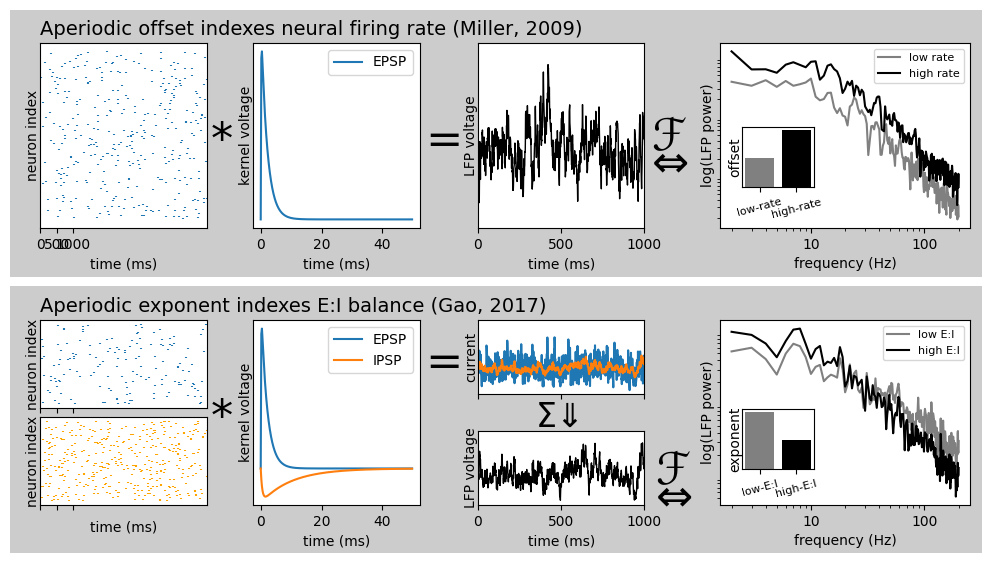

In [20]:
# b
# settings
size_inset_text = 8
eq_size = 32
eq_size_2 = 24

# create figure and gridspec
fig = plt.figure(figsize=[12,6], tight_layout=True)
spec = gridspec.GridSpec(2, 1, figure=fig, hspace=0.5, wspace=0.5)

# create gridspec for each row (model)
eq_ax_size = 0.35
gs_r0 = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=spec[0,0], width_ratios=[1,eq_ax_size*0.8,1,eq_ax_size,1,eq_ax_size*1.3,1.5], 
                                         height_ratios=[1], wspace=0)
gs_r1 = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=spec[1,0], width_ratios=[1,eq_ax_size*0.8,1,eq_ax_size,1,eq_ax_size*1.3,1.5], 
                                         height_ratios=[1], wspace=0)
ax_r0 = fig.add_subplot(spec[0,0])
ax_r0.set_axis_off()
ax_r0.set_title('Aperiodic offset indexes neural firing rate (Miller, 2009)', 
                fontsize=14, loc='left')

ax_r1 = fig.add_subplot(spec[1,0])
ax_r1.set_axis_off()
ax_r1.set_title('Aperiodic exponent indexes E:I balance (Gao, 2017)', 
                fontsize=14, loc='left')

########## Row 1: offset model ##########
ax_1b = fig.add_subplot(gs_r0[0,0])
ax_1c = fig.add_subplot(gs_r0[0,2])
ax_1d = fig.add_subplot(gs_r0[0,4])
ax_1e = fig.add_subplot(gs_r0[0,6])

# plot subplot 1b
ax_1b.eventplot(spike_times_0)
ax_1b.set(xlabel="time (ms)", ylabel="neuron index")

# plot subplot 1c
ax_1c.plot(time_ke*1000, kernel_e, label="EPSP")
ax_1c.set(xlabel="time (ms)", ylabel="kernel voltage")
ax_1c.legend()

# plot subplot 1d
# create nested gridspec
ax_1d.plot(t_lfp_0*1000, lfp_0, color='k', linewidth=1)
ax_1d.set(xlabel="time (ms)", ylabel="LFP voltage")

# plot subplot 1e
ax_1e.loglog(freq, spectra_0, color='grey')
ax_1e.loglog(freq, spectra_1, color='k')
ax_1e.set(xlabel="frequency (Hz)", ylabel="log(LFP power)")
ax_1e.legend(labels=["low rate","high rate"], loc="upper right", fontsize=size_inset_text)

# plot subplot 1f (embedding in 1e)
ax_1f = fig.add_axes([.71, 0.64, .06, .1], zorder=10, anchor='SW')
ax_1f.bar([0,1], [1,2], color=['grey','k']) # TEMP - placeholder
ax_1f.set(ylabel="offset")
ax_1f.set_xticks([0,1])
ax_1f.set_xticklabels(['low-rate', 'high-rate'], rotation=15, fontsize=size_inset_text)
### Plot bottom row ###################################################

# plot subplot 2b
# create nested gridspec
gs_r2_b = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_r1[0,0], hspace=0.1)
ax_2b_a = fig.add_subplot(gs_r2_b[0,0])
ax_2b_a.eventplot(spiketimes_e)

ax_2b_b = fig.add_subplot(gs_r2_b[1,0])
ax_2b_b.eventplot(spiketimes_i, color='orange')
ax_2b_b.set(xlabel="time", ylabel="neuron index")

# plot subplot 2c
ax_2c = fig.add_subplot(gs_r1[0,2])
ax_2c.plot(time_ke*1000, kernel_e, label='EPSP')
ax_2c.plot(time_ki*1000, -kernel_i, label='IPSP')
ax_2c.set(xlabel="time (ms)", ylabel="kernel voltage")
ax_2c.legend()

# plot subplot 2d
gs_r2_d = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_r1[0,4], height_ratios=[1,0.5,1], hspace=0)
ax_2d_eq = fig.add_subplot(gs_r2_d[1,0])
ax_2d_eq.set_axis_off()
ax_2d_eq.text(0.35,0.1, "\u03A3\u21d3", size=eq_size_2)

ax_2d_a = fig.add_subplot(gs_r2_d[0,0])
# ax_2d_a.plot(t_lfp_2*1000, conductance_e+np.max(conductance_i), label='excitatory')
ax_2d_a.plot(t_lfp_2*1000, conductance_e, label='excitatory')
ax_2d_a.plot(t_lfp_2*1000, conductance_i, label='inhibitory')
ax_2d_a.set(ylabel="current")

ax_2d_b = fig.add_subplot(gs_r2_d[2,0])
ax_2d_b.plot(t_lfp_2*1000, lfp_2, color='k', linewidth=1)
ax_2d_b.set(xlabel="time (ms)", ylabel="LFP voltage")

# plot subplot 2e
ax_2e = fig.add_subplot(gs_r1[0,6])
ax_2e.loglog(freq, spectra_3, color='grey')
ax_2e.loglog(freq, spectra_2, color='k')
ax_2e.set(xlabel="frequency (Hz)", ylabel="log(LFP power)")
ax_2e.legend(labels=["low E:I","high E:I"], loc="upper right", fontsize=size_inset_text)

# plot subplot 2f (embedding in 2d)
ax_2f = fig.add_axes([.71, 0.17, .06, .1], zorder=10, anchor='SW')
ax_2f.bar([0,1], [2,1], color=['grey','k']) # TEMP - placeholder
ax_2f.set(ylabel="exponent")
ax_2f.set_xticks([0,1])
ax_2f.set_xticklabels(['low-E:I', 'high-E:I'], rotation=15, fontsize=size_inset_text)
# set x limits
for ax in[ax_1d, ax_2d_a, ax_2d_b]:
    ax.set_xlim([0, 1000])
for ax in[ax_1b, ax_2b_a, ax_2b_b]:
    ax.set_xlim([0, 1])

# adjust axis ticks and labels
for ax in [ax_1b, ax_1c, ax_1d, ax_1e, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, ax_2d_b, ax_2e, ax_2f]:
    # ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])

for ax in[ax_2b_a, ax_2d_a]:
    ax.set_xticklabels([])

for ax in [ax_1b, ax_1c, ax_1d, ax_1f, ax_2b_a, ax_2b_b, ax_2c, ax_2d_a, ax_2d_b, ax_2f]:
    ax.yaxis.set_label_coords(0, .5)
for ax in [ax_1e, ax_2e]:
    ax.yaxis.set_label_coords(-0.02, .5)

for ax in[ax_1e, ax_2e]:
    ax.set_xticks([10,100])
    ax.set_xticklabels(('10', '100'))
    
for ax in[ax_1d, ax_2d_b]:
    ax.set_xticks([0, 500, 1000])
    ax.set_xticklabels(('0', '500', '1000'))
    
for ax in [ax_1b, ax_2b_b]:
    ax.set_xticks([0, 0.1, 0.2])
    ax.set_xticklabels(('0', '500', '1000'))
    ax.set(xlabel="time (ms)", ylabel="neuron index")
ax_2b_a.set_xticks([0, 0.1, 0.2])
ax.set_xticklabels([])
ax_2b_a.set(xlabel="", ylabel="neuron index")

# add equation symbols between plots
ax_1eq0 = fig.add_subplot(gs_r0[0,1])
ax_1eq1 = fig.add_subplot(gs_r0[0,3])
ax_1eq2 = fig.add_subplot(gs_r0[0,5])
ax_2eq0 = fig.add_subplot(gs_r1[0,1])
ax_2eq1 = fig.add_subplot(gs_r1[0,3])
ax_2eq2 = fig.add_subplot(gs_r1[0,5])

for ax in [ax_1eq0, ax_1eq1, ax_1eq2, ax_2eq0, ax_2eq1, ax_2eq2]:
    ax.set_axis_off()
ax_1eq0.text(0.1, 0.4, "\u002a", size=eq_size)
ax_1eq1.text(0.1, 0.4, "=", size=eq_size)
ax_1eq2.text(0.1, 0.28, "\u2131 \n\u21D4", size=eq_size, linespacing=0.5)

ax_2eq0.text(0.1, 0.4, "\u002a", size=eq_size)
ax_2eq1.text(0.1, 0.7, "=", size=eq_size)
ax_2eq2.text(0.15, -0.03, "\u2131 \n\u21D4", size=eq_size, linespacing=0.5)

# color each row
fig.add_artist(Rectangle((0.1, 0.49), width=0.81, height=0.445, facecolor='grey', alpha=0.4, zorder=0))
fig.add_artist(Rectangle((0.1, 0.03), width=0.81, height=0.445, facecolor='grey', alpha=0.4, zorder=0))

plt.savefig(f'{PROJECT_PATH}/figures/sfn_2023/panel_1/gao_miller.png')

plt.show()